In [20]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os



In [21]:
device="cuda" if torch.cuda.is_available() else "cpu"
print("device:",device)


device: cuda


In [22]:
image_path=[]
labels=[]
for i in os.listdir("/kaggle/input/animal-faces/afhq"):
    print(i)
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        print(label)
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
            print (image)
            break
        break
    break

val
dog
flickr_dog_000254.jpg


In [23]:
image_path=[]
labels=[]
for i in os.listdir("/kaggle/input/animal-faces/afhq"):
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
          image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
          labels.append(label)

data_df=pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])
print(data_df['labels'].unique())
data_df.head


['dog' 'wild' 'cat']


<bound method NDFrame.head of                                               image_path labels
0      /kaggle/input/animal-faces/afhq/val/dog/flickr...    dog
1      /kaggle/input/animal-faces/afhq/val/dog/pixaba...    dog
2      /kaggle/input/animal-faces/afhq/val/dog/flickr...    dog
3      /kaggle/input/animal-faces/afhq/val/dog/flickr...    dog
4      /kaggle/input/animal-faces/afhq/val/dog/pixaba...    dog
...                                                  ...    ...
16125  /kaggle/input/animal-faces/afhq/train/cat/pixa...    cat
16126  /kaggle/input/animal-faces/afhq/train/cat/pixa...    cat
16127  /kaggle/input/animal-faces/afhq/train/cat/pixa...    cat
16128  /kaggle/input/animal-faces/afhq/train/cat/pixa...    cat
16129  /kaggle/input/animal-faces/afhq/train/cat/pixa...    cat

[16130 rows x 2 columns]>

In [24]:
train = data_df.sample(frac=0.7, random_state=7)
temp = data_df.drop(train.index)

val = temp.sample(frac=0.5, random_state=7)
test = temp.drop(val.index)


In [25]:
train = data_df.sample(frac=0.7, random_state=7)
temp = data_df.drop(train.index)

val = temp.sample(frac=0.5, random_state=7)
test = temp.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [26]:


label_encoder = LabelEncoder() 
label_encoder.fit(data_df['labels']) 
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.ConvertImageDtype(torch.float) 
    ]) 
     

In [27]:
print(data_df["labels"].unique())
print(type(data_df.iloc[0, 1]))


['dog' 'wild' 'cat']
<class 'str'>


In [28]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.labels = label_encoder.transform(dataframe['labels'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.labels[idx])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [29]:
train_dataset=CustomImageDataset(dataframe=train,transform=transform)
val_dataset=CustomImageDataset(dataframe=val,transform=transform)
test_dataset=CustomImageDataset(dataframe=test,transform=transform)

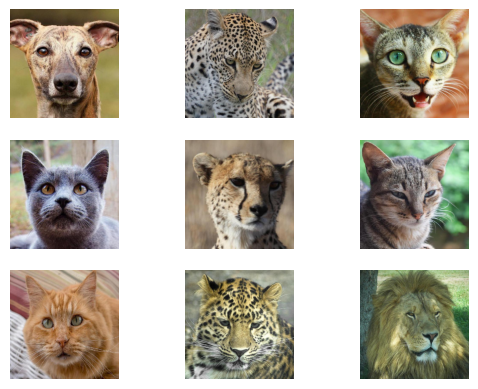

In [30]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [31]:
LR=1e-4
EPOCHS=10


In [42]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pooling=nn.MaxPool2d(2,2)
        self.silu=nn.SiLU()

        self.flatten=nn.Flatten()
        self.linear=nn.Linear((128*16*16),128)
        self.output=nn.Linear(128,len(data_df['labels'].unique()))

    def forward(self,x):
        x=self.conv1(x)
        x=self.pooling(x)
        x=self.silu(x)
        x=self.conv2(x)
        x=self.pooling(x)
        x=self.silu(x)
        x=self.conv3(x)
        x=self.pooling(x)
        x=self.silu(x)
        x=self.flatten(x)
        x=self.linear(x)
        x=self.output(x)

        return x
model=Net().to(device)        

In [34]:
from torchsummary import summary
summary(model,input_size=(3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              SiLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              SiLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [35]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)

In [38]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):

    print(f"Epoch {epoch+1}/{EPOCHS} started")

    model.train()
    total_acc_train = 0
    total_loss_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):

        if batch_idx % 20 == 0:
            print(f"Train batch {batch_idx}/{len(train_loader)}")

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)

        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item()
        total_acc_train += (torch.argmax(outputs, dim=1) == labels).sum().item()

    model.eval()
    total_loss_val = 0
    total_acc_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):

            if batch_idx % 20 == 0:
                print(f"Val batch {batch_idx}/{len(val_loader)}")

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            total_loss_val += val_loss.item()
            total_acc_val += (torch.argmax(outputs, dim=1) == labels).sum().item()

    train_loss_avg = total_loss_train / len(train_loader)
    val_loss_avg = total_loss_val / len(val_loader)

    train_acc = (total_acc_train / len(train_dataset)) * 100
    val_acc = (total_acc_val / len(val_dataset)) * 100

    total_loss_train_plot.append(round(train_loss_avg, 4))
    total_loss_validation_plot.append(round(val_loss_avg, 4))
    total_acc_train_plot.append(round(train_acc, 4))
    total_acc_validation_plot.append(round(val_acc, 4))

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss_avg:.4f} Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss_avg:.4f} Validation Accuracy: {val_acc:.2f}%")
    print("=" * 25)


Epoch 1/10 started
Train batch 0/353
Train batch 20/353
Train batch 40/353
Train batch 60/353
Train batch 80/353
Train batch 100/353
Train batch 120/353
Train batch 140/353
Train batch 160/353
Train batch 180/353
Train batch 200/353
Train batch 220/353
Train batch 240/353
Train batch 260/353
Train batch 280/353
Train batch 300/353
Train batch 320/353
Train batch 340/353
Val batch 0/76
Val batch 20/76
Val batch 40/76
Val batch 60/76
Epoch 1/10
Train Loss: 0.2274 Train Accuracy: 91.79%
Validation Loss: 0.2103 Validation Accuracy: 92.81%
Epoch 2/10 started
Train batch 0/353
Train batch 20/353
Train batch 40/353
Train batch 60/353
Train batch 80/353
Train batch 100/353
Train batch 120/353
Train batch 140/353
Train batch 160/353
Train batch 180/353
Train batch 200/353
Train batch 220/353
Train batch 240/353
Train batch 260/353
Train batch 280/353
Train batch 300/353
Train batch 320/353
Train batch 340/353
Val batch 0/76
Val batch 20/76
Val batch 40/76
Val batch 60/76
Epoch 2/10
Train Loss: 

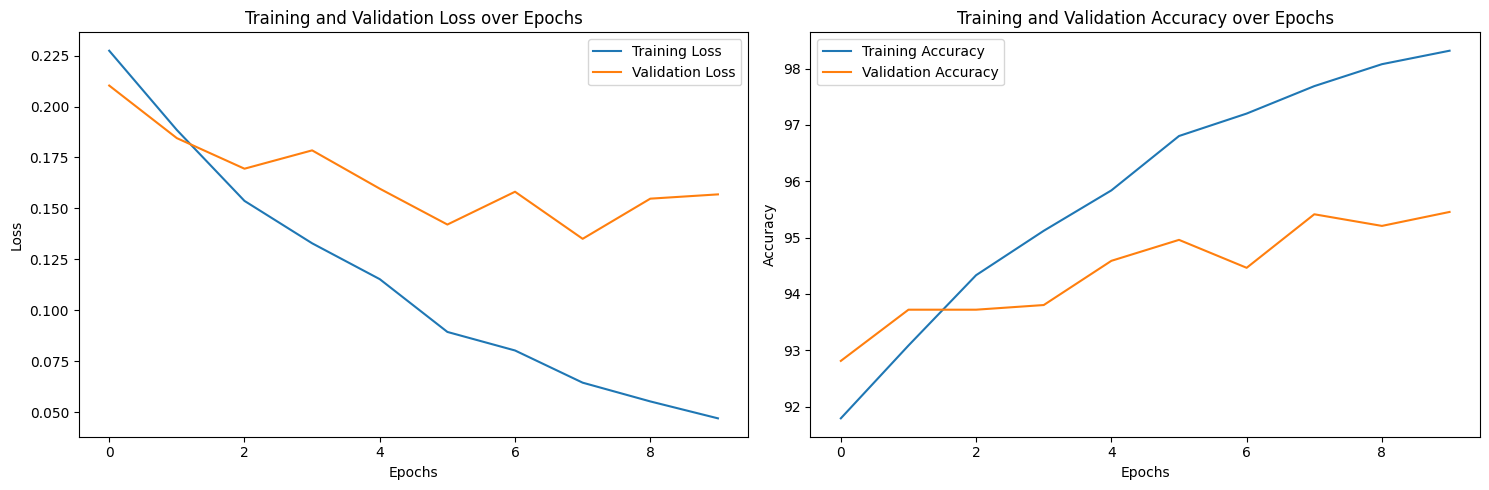

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

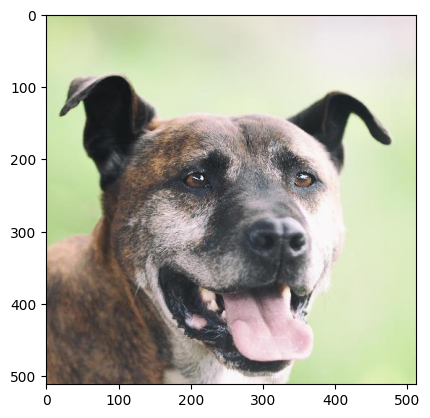


Prediction: 



array(['dog'], dtype=object)

In [46]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])


image = Image.open("/kaggle/input/animal-faces/afhq/train/dog/flickr_dog_000010.jpg")
plt.imshow(image)
plt.show()


print()
print("Prediction: \n")
predict_image("/kaggle/input/animal-faces/afhq/train/dog/flickr_dog_000010.jpg")
     
